In [1]:
import numpy as np
import pandas as pd
from array import array
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
%matplotlib inline
from matplotlib_venn import venn2
import seaborn as sns
import anndata as ad
import phagepy as pp
import scanpy as sc
import scipy.stats as ss
import scipy
import phagepy.analysis as analysis
import re
import os
from collections import Counter
import scipy.stats as stats
from Bio import SeqIO

In [2]:
# define output folder for figures
fig_dir='/path/to/output_figs/'

In [3]:
# define directory for source and output files
dir='/path/to/source_files/'

# Read/write

In [4]:
# import CBM metadata and counts data (two rounds of sequencing)
cbm_meta1 = dir+"cbm_metadata.csv"
cbm_meta2 = dir+"cbm_metadata2.csv"
cbm_counts1 = dir+"cbm_raw_rpk.csv"
cbm_counts2 = dir+"cbm_raw_rpk2.csv"
# import BD metadata and counts data
bd_meta = dir+"bd_metadata.csv"
bd_counts = dir+"bd_raw_rpk.csv"

In [5]:
# create anndata object for CMB cohort
cbm1=pp.create_anndata(cbm_counts1, cbm_meta1)
cbm2=pp.create_anndata(cbm_counts2, cbm_meta2)

/data/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/data/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [6]:
# create anndata object for BD cohort
bd=pp.create_anndata(bd_counts, bd_meta)

/data/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [7]:
# concatenate both CBM objects and delete individual objects
cbm = ad.concat([cbm1, cbm2], index_unique="-")
del cbm1
del cbm2
cbm

AnnData object with n_obs × n_vars = 307 × 239640
    obs: 'sample_type', 'plate', 'well', 'sample_id', 'rerun', 'group', 'age', 'sex', 'heart_dz', 'sero'

# filter out low readcount samples from CBM

In [8]:
# import readcount data
cbm_count = pd.read_csv(dir+"cbm_readcounts.csv")
cbm_count2 = pd.read_csv(dir+"cbm_readcounts2.csv")

In [9]:
# Label samples as run 1 (0) or rerun (1) to differentiate and then merge dataframes
cbm_count2['rerun'] = 1
cbm_count['rerun'] = 0
cbm_count = pd.concat([cbm_count, cbm_count2])
cbm_count.head()

,Sample Name,Read Counts,rerun
0,CHAGAS_P3A10_BLANK_R1_001,1043027,0
1,CHAGAS_P3A11_BLANK_R1_001,950737,0
2,CHAGAS_P3A12_HC001_R1_001,1077714,0
3,CHAGAS_P3A1_BIO_6275-100uL_R1_001,1266457,0
4,CHAGAS_P3A2_BIO_6304-100uL_R1_001,1356163,0


In [10]:
# drop samples with read counts below 4E5 reads (less than 2X coverage)
cbm_drop = cbm_count[cbm_count['Read Counts'] < 4e5]
cbm_drop.shape

(23, 3)

In [11]:
# Make list of samples to drop and add -1 or -0 to end of id string to match obs_names in merged adata object
cbm_drop = cbm_drop.copy()
cbm_drop['rerun'] = cbm_drop['rerun'].apply(str)
cbm_drop['id'] = cbm_drop['Sample Name'] + '-' + cbm_drop['rerun'].astype(str)

In [12]:
# Drop these samples from cbm adata object
exclude = cbm_drop['id'].tolist()
cbm = cbm[~cbm.obs_names.isin(exclude)]
cbm

View of AnnData object with n_obs × n_vars = 284 × 239640
    obs: 'sample_type', 'plate', 'well', 'sample_id', 'rerun', 'group', 'age', 'sex', 'heart_dz', 'sero'

# pseudocount rpk values

In [13]:
# Pseudocount rpk values to avoid inflation by division
for i, ad in enumerate([cbm, bd]):
    
    ad = ad.copy()
    ad.X = ad.X + 1
    
    if i == 0:
        cbm = ad
    else:
        bd = ad

# check pseudocounting - should see array with values 1.0 and greater
cbm.X

array([[1.       , 1.       , 2.1504974, ..., 1.       , 1.       ,
        1.       ],
       [1.       , 1.       , 1.       , ..., 1.       , 1.       ,
        1.       ],
       [1.       , 1.185578 , 1.       , ..., 1.       , 1.       ,
        1.       ],
       ...,
       [1.       , 1.3763283, 1.6021254, ..., 1.       , 1.       ,
        1.       ],
       [1.       , 1.2308639, 1.9234555, ..., 1.       , 1.       ,
        1.       ],
       [1.       , 1.       , 2.015925 , ..., 1.       , 1.       ,
        1.       ]], dtype=float32)

# load p2g data

In [14]:
# load peptide-to-gene mapping file
pep2gene=pd.read_csv(dir+'p2g_mapping.csv', index_col=0, header=0)
pep2gene.head()

,nt_seq,refseq_id,uniprot_id,protein,gene,organism,full prot,seq,stage
peptide,,,,,,,,,
XP_802133.1_cystathionine_beta-synthase_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag1,AACGGGTGCTTCCATTTACTCCCGTTCCTATTTACCTTGTTGCTTT...,XP_802133.1,Q4CK85_TRYCC,"Cystathionine beta-synthase, putative",Tc00.1047053447925.10,Trypanosoma cruzi (strain CL Brener),NGCFHLLPFLFTLLLLLFVFPIGGEDVQIMAQNPSAVNNKKEVPDR...,NGCFHLLPFLFTLLLLLFVFPIGGEDVQIMAQNPSAVNNKKEVPDRR,NaN
XP_802133.1_cystathionine_beta-synthase_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag2,GGTGAGGACGTCCAGATAATGGCGCAAAATCCTTCCGCTGTTAACA...,XP_802133.1,Q4CK85_TRYCC,"Cystathionine beta-synthase, putative",Tc00.1047053447925.10,Trypanosoma cruzi (strain CL Brener),NGCFHLLPFLFTLLLLLFVFPIGGEDVQIMAQNPSAVNNKKEVPDR...,GEDVQIMAQNPSAVNNKKEVPDRRTCILDTVLDAIGSTHCIRLNHVP,NaN
XP_802134.1_heat_shock_protein_70_(HSP70)_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag1,GTAGCGTTTACAGAAACGGAGCGGCTGATTGGAGACGGGGCAAAGA...,XP_802134.1,Q4CK86_TRYCC,"Heat shock protein 70 (HSP70), putative",Tc00.1047053418069.10,Trypanosoma cruzi (strain CL Brener),VAFTETERLIGDGAKNQLPQNPHNTIYAIKRLIGRKYSDATVQTDK...,VAFTETERLIGDGAKNQLPQNPHNTIYAIKRLIGRKYSDATVQTDKK,NaN
XP_802134.1_heat_shock_protein_70_(HSP70)_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag2,ATAAAACGTTTGATCGGAAGGAAATATTCTGATGCAACAGTCCAGA...,XP_802134.1,Q4CK86_TRYCC,"Heat shock protein 70 (HSP70), putative",Tc00.1047053418069.10,Trypanosoma cruzi (strain CL Brener),VAFTETERLIGDGAKNQLPQNPHNTIYAIKRLIGRKYSDATVQTDK...,IKRLIGRKYSDATVQTDKKLLSYEVVADKDGKPKVQVEVGGKKKQFT,NaN
XP_802134.1_heat_shock_protein_70_(HSP70)_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag3,AAAGATGGAAAGCCTAAAGTGCAGGTCGAAGTTGGGGGCAAGAAAA...,XP_802134.1,Q4CK86_TRYCC,"Heat shock protein 70 (HSP70), putative",Tc00.1047053418069.10,Trypanosoma cruzi (strain CL Brener),VAFTETERLIGDGAKNQLPQNPHNTIYAIKRLIGRKYSDATVQTDK...,KDGKPKVQVEVGGKKKQFTPEEVSAMVLQKMKEIAETYLGEKVKNAV,NaN


In [15]:
# add gene mapping information to each anndata object

# list of column names to add
p2g = ['refseq_id', 'gene', 'protein', 'seq', 'stage']

# list of anndata objects
adata_list = [cbm, bd]

for col in p2g:
    
    col_to_dict = pep2gene[col].to_dict()
    
    for ad in adata_list:
        ad.var[col] = ad.var.index.map(col_to_dict)

# check that gene mapping data has been added appropriately
cbm.var.head()

,refseq_id,gene,protein,seq,stage
peptide,,,,,
XP_802133.1_cystathionine_beta-synthase_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag1,XP_802133.1,Tc00.1047053447925.10,"Cystathionine beta-synthase, putative",NGCFHLLPFLFTLLLLLFVFPIGGEDVQIMAQNPSAVNNKKEVPDRR,NaN
XP_802133.1_cystathionine_beta-synthase_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag2,XP_802133.1,Tc00.1047053447925.10,"Cystathionine beta-synthase, putative",GEDVQIMAQNPSAVNNKKEVPDRRTCILDTVLDAIGSTHCIRLNHVP,NaN
XP_802134.1_heat_shock_protein_70_(HSP70)_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag1,XP_802134.1,Tc00.1047053418069.10,"Heat shock protein 70 (HSP70), putative",VAFTETERLIGDGAKNQLPQNPHNTIYAIKRLIGRKYSDATVQTDKK,NaN
XP_802134.1_heat_shock_protein_70_(HSP70)_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag2,XP_802134.1,Tc00.1047053418069.10,"Heat shock protein 70 (HSP70), putative",IKRLIGRKYSDATVQTDKKLLSYEVVADKDGKPKVQVEVGGKKKQFT,NaN
XP_802134.1_heat_shock_protein_70_(HSP70)_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag3,XP_802134.1,Tc00.1047053418069.10,"Heat shock protein 70 (HSP70), putative",KDGKPKVQVEVGGKKKQFTPEEVSAMVLQKMKEIAETYLGEKVKNAV,NaN


# drop duplicates
- The CBM cohort had re-run samples and technical replicates - need to drop
- Use 1st run when present
- Use sample with higher read counts when duplicates are technical replicates from the same sequencing run

In [16]:
# identify duplicates in 'sample_id' column
duplicates_mask = cbm.obs.duplicated(subset='sample_id', keep=False)

# identify duplicates where index ends with '-1' (rerun samples)
index_condition = cbm.obs.index.str.endswith('-1')

# identify samples to drop (duplicates from a second sequencing run)
samples_to_drop = cbm.obs[duplicates_mask & index_condition].index

# drop samples
cbm = cbm[~cbm.obs.index.isin(samples_to_drop)]
cbm

View of AnnData object with n_obs × n_vars = 275 × 239640
    obs: 'sample_type', 'plate', 'well', 'sample_id', 'rerun', 'group', 'age', 'sex', 'heart_dz', 'sero'
    var: 'refseq_id', 'gene', 'protein', 'seq', 'stage'

In [17]:
# check for additional duplicates
cbm.obs['sample_id'][cbm.obs.duplicated(subset='sample_id', keep=False)].unique()

array(['BLANK', 'HC001', 'HC002'], dtype=object)

In [18]:
# HC001 and HC002 were run twice for plate batch qc, but for downstream analysis we only need one of each - check read counts and then drop one
sample_id_to_keep = ['CHAGAS_P3A12_HC001_R1_001',
                     'CHAGAS_P5A1_HC001_R1_001',
                     'CHAGAS_P4A12_HC002_R1_001',
                     'CHAGAS_P5A2_HC002_R1_001']

# check read counts to drop replicates with lower read counts
hc_count= cbm_count[cbm_count['Sample Name'].isin(sample_id_to_keep)].copy()
hc_count

,Sample Name,Read Counts,rerun
2,CHAGAS_P3A12_HC001_R1_001,1077714,0
98,CHAGAS_P4A12_HC002_R1_001,1011604,0
195,CHAGAS_P5A1_HC001_R1_001,1241833,0
196,CHAGAS_P5A2_HC002_R1_001,1306482,0


In [19]:
# the samples run on Plate 5 have higher read counts, so use these
ids_to_drop = ['CHAGAS_P3A12_HC001_R1_001-0',
               'CHAGAS_P4A12_HC002_R1_001-0',]

# filter out the lower read count ids
cbm = cbm[~cbm.obs_names.isin(ids_to_drop)]
cbm

View of AnnData object with n_obs × n_vars = 273 × 239640
    obs: 'sample_type', 'plate', 'well', 'sample_id', 'rerun', 'group', 'age', 'sex', 'heart_dz', 'sero'
    var: 'refseq_id', 'gene', 'protein', 'seq', 'stage'

In [20]:
# check one last time that there are no duplicates - there should only be "BLANK" wells duplicated
print("Duplicated samples:", cbm.obs['sample_id'][cbm.obs.duplicated(subset='sample_id', keep=False)].unique())

Duplicated samples: ['BLANK']


# remove AG beads

In [21]:
# Drop AG beads control wells from adata object
# BD cohort was not run with AG beads, so only need to apply to CBM set
cbm=cbm.copy()
cbm=pp.define_ctrl_set_locs(cbm, obs_key='group', obs_value='AG_bead')
cbm=pp.define_ctrl_set(cbm)
cbm

View of AnnData object with n_obs × n_vars = 230 × 239640
    obs: 'sample_type', 'plate', 'well', 'sample_id', 'rerun', 'group', 'age', 'sex', 'heart_dz', 'sero'
    var: 'refseq_id', 'gene', 'protein', 'seq', 'stage'
    uns: 'control_ids'
    varm: 'X_control'

# rpk filter - remove peptides with no reads across all samples

In [22]:
# define list of adata objects and an empty dictionary to store results
adata_list = {'cbm': cbm, 'bd': bd}
peptide_dataframes = {}

# loop through each adata object and sum rpk across peptides
for name, xdata in adata_list.items():
    
    df_peptides = pd.DataFrame(
        data=np.sum(xdata.X, axis=0),
        index=xdata.var_names,
        columns=['sum_rpk_per_pep']
    )
    
    # store the sum data in the dictionary with a key based on the adata name
    peptide_dataframes[name] = df_peptides

# Check that this looks right
peptide_dataframes['cbm'].head()

,sum_rpk_per_pep
peptide,
XP_802133.1_cystathionine_beta-synthase_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag1,233.502060
XP_802133.1_cystathionine_beta-synthase_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag2,268.226166
XP_802134.1_heat_shock_protein_70_(HSP70)_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag1,581.212952
XP_802134.1_heat_shock_protein_70_(HSP70)_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag2,361.277466
XP_802134.1_heat_shock_protein_70_(HSP70)_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag3,402.800751


In [23]:
# Check that all peptides are accounted for (should be 239640 - the library includes additional non-T. cruzi peptides that will be dropped later)
len(peptide_dataframes['cbm'].index)

239640

In [24]:
len(peptide_dataframes['bd'].index)

239640

In [25]:
# figure out how many peptides are left after filtering for 0-rpk peptides (sum of rpk = total peptide count)

filtered_peptides = {}

for name, df in peptide_dataframes.items():
    rpk_filt = len(adata_list[name].obs)
    filtered_peptides[name] = df[df['sum_rpk_per_pep'] > rpk_filt].index

len(filtered_peptides['cbm']), len(filtered_peptides['bd'])

(228251, 228366)

In [26]:
cbm = cbm.copy()
cbm.uns['control_ids']=cbm.uns['control_ids'].tolist()

In [27]:
# filter out no-read peptides from adata objects
cbm=cbm[:,cbm.var_names.isin(filtered_peptides['cbm'])]
bd=bd[:,bd.var_names.isin(filtered_peptides['bd'])]
cbm.shape, bd.shape

((230, 228251), (92, 228366))

# z-score over healthy background

In [28]:
def z_score_loo(ad, control_key, control_value, layer_name="z_score"):
    """
    Z-scores each sample in an AnnData object relative to control samples.
    Control samples are z-scored by leaving themselves out from the mean and std dev calculations,
    while non-control samples are z-scored relative to all controls.
    
    Parameters
    ----------
    ad : anndata.AnnData
        The AnnData object to perform z-scoring on.
    control_key : str
        Column in `ad.obs` specifying sample groups (e.g., "Group").
    control_value : str
        The value in `control_key` that indicates a control sample (e.g., "control").
    layer_name : str, optional
        The name of the layer where the z-scored data will be stored.
    
    Returns
    -------
    None
        The function modifies the AnnData object in place, adding a layer with the z-scored values.
    """
    # identify control and non-control indices
    control_mask = ad.obs[control_key] == control_value
    non_control_mask = ~control_mask
    
    # initialize an array to store the z-scored data
    z_scores = np.empty(ad.X.shape)
    
    # calculate mean and std dev for all controls (used for non-control samples)
    all_control_data = ad.X[control_mask]
    control_mean = np.mean(all_control_data, axis=0)
    control_std = np.std(all_control_data, axis=0)
    
    # z-score non-control samples using mean and std dev of all controls
    z_scores[non_control_mask] = (ad.X[non_control_mask] - control_mean) / control_std
    
    # z-score control samples with leave-one-out approach
    for i, control_index in enumerate(np.where(control_mask)[0]):
        leave_one_out_data = np.delete(all_control_data, i, axis=0)
        leave_one_out_mean = np.mean(leave_one_out_data, axis=0)
        leave_one_out_std = np.std(leave_one_out_data, axis=0)
        z_scores[control_index] = (ad.X[control_index] - leave_one_out_mean) / leave_one_out_std
    
    # save the z-scores in a new layer
    ad.layers[layer_name] = z_scores
    
    return None 

In [29]:
# z-score, expecting to get warnings for divide by zero (some peptides have reads in cases but not in controls)
# have checked - these are very low signal peptides
z_score_loo(cbm, 'sero', 'seronegative')
z_score_loo(bd, 'sero', 'seronegative')

/tmp/ipykernel_230017/1987765812.py:36: RuntimeWarning: divide by zero encountered in divide
  z_scores[non_control_mask] = (ad.X[non_control_mask] - control_mean) / control_std
/tmp/ipykernel_230017/1987765812.py:36: RuntimeWarning: invalid value encountered in divide
  z_scores[non_control_mask] = (ad.X[non_control_mask] - control_mean) / control_std
/tmp/ipykernel_230017/1987765812.py:43: RuntimeWarning: divide by zero encountered in divide
  z_scores[control_index] = (ad.X[control_index] - leave_one_out_mean) / leave_one_out_std
/tmp/ipykernel_230017/1987765812.py:43: RuntimeWarning: invalid value encountered in divide
  z_scores[control_index] = (ad.X[control_index] - leave_one_out_mean) / leave_one_out_std
/tmp/ipykernel_230017/1987765812.py:46: ImplicitModificationWarning: Setting element `.layers['z_score']` of view, initializing view as actual.
  ad.layers[layer_name] = z_scores


In [30]:
def filter_infinite_vars(ad, layer_name):
    """
    Filter out variables with infinity values in the 'z_rpk' layer from the AnnData object.
    Make sure to check that these are not high rpk peptides in the disease group

    Parameters
    ----------
    adata : anndata.AnnData
        The AnnData object to filter.

    Returns
    -------
    anndata.AnnData
        A new AnnData object with variables without infinite values in the 'z_rpk' layer.
    """
    # identify variables with infinity values in the specified layer
    inf_mask = np.isinf(ad.layers[layer_name]).any(axis=0)
    var_indices_to_keep = ~inf_mask
    
    # subset the adata object to keep only the variables that do not contain inf
    adata_filtered = ad[:, var_indices_to_keep].copy()
    
    return adata_filtered

In [31]:
cbm = filter_infinite_vars(cbm, 'z_score')
bd = filter_infinite_vars(bd, 'z_score')

In [32]:
cbm

AnnData object with n_obs × n_vars = 230 × 227356
    obs: 'sample_type', 'plate', 'well', 'sample_id', 'rerun', 'group', 'age', 'sex', 'heart_dz', 'sero'
    var: 'refseq_id', 'gene', 'protein', 'seq', 'stage'
    uns: 'control_ids'
    varm: 'X_control'
    layers: 'z_score'

In [33]:
bd

AnnData object with n_obs × n_vars = 92 × 227018
    obs: 'plate_well', 'BirthReg', 'birth_country', 'sero', 'group', 'region'
    var: 'refseq_id', 'gene', 'protein', 'seq', 'stage'
    layers: 'z_score'

# SFig 3 - Moving threshold analysis to determine z-score cutoff for hit calling

## CBM

In [34]:
# extract df with pt ids and z-scores
z_score_cbm = pd.DataFrame(data=cbm.layers['z_score'], columns=cbm.var_names, index=cbm.obs_names).T
## check that sample names are column names 
z_score_cbm.head()

,CHAGAS_P3A1_BIO_6275-100uL_R1_001-0,CHAGAS_P3A2_BIO_6304-100uL_R1_001-0,CHAGAS_P3A3_BIO_6333-100uL_R1_001-0,CHAGAS_P3A4_BIO_6200-500ul_R1_001-0,CHAGAS_P3A5_BIO_6286-100ul_R1_001-0,CHAGAS_P3A6_BIO_6307-100ul_R1_001-0,CHAGAS_P3A7_BIO_6350-100ul_R1_001-0,CHAGAS_P3A8_BIO_6247-500ul_R1_001-0,CHAGAS_P3A9_BIO_6105-200ul_R1_001-0,CHAGAS_P3B1_BIO_6277-100uL_R1_001-0,...,CHAGAS_P5H12_GFAP_5_R1_001-0,CHAGAS_P5H1_HC085_R1_001-0,CHAGAS_P5H2_HC086_R1_001-0,CHAGAS_P5H3_HC087_R1_001-0,CHAGAS_P5H4_HC088_R1_001-0,CHAGAS_P5H5_HC089_R1_001-0,CHAGAS_P5H6_HC090_R1_001-0,CHAGAS_P5H7_HC091_R1_001-0,CHAGAS_P5H8_HC092_R1_001-0,CHAGAS_P5H9_HC093_R1_001-0
peptide,,,,,,,,,,,,,,,,,,,,,
XP_802133.1_cystathionine_beta-synthase_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag1,-0.152610,-0.152610,-0.152610,0.539198,0.566712,0.549349,-0.152610,-0.152610,-0.153300,-0.152610,...,-0.152610,-0.153300,-0.153300,0.561471,-0.153300,-0.153300,-0.153300,-0.153300,-0.153300,-0.153300
XP_802133.1_cystathionine_beta-synthase_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag2,0.018347,-0.282933,-0.142088,-0.282933,-0.282933,-0.134274,-0.282933,-0.282933,-0.110190,0.484504,...,-0.282933,0.409404,-0.284283,0.320782,32.051140,-0.146124,0.316974,-0.284283,-0.125260,-0.284283
XP_802134.1_heat_shock_protein_70_(HSP70)_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag1,0.024331,0.188643,-0.124589,0.071060,-0.000801,-0.227727,-0.172247,-0.255325,-0.256526,-0.112854,...,0.196641,-0.050525,0.050847,-0.088033,-0.073574,-0.256526,-0.172793,-0.196334,-0.079427,-0.256526
XP_802134.1_heat_shock_protein_70_(HSP70)_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag2,0.016406,-0.109940,-0.318345,0.766896,-0.318345,-0.318345,0.123636,-0.318345,-0.319894,-0.204652,...,-0.318345,-0.011627,-0.217618,-0.319894,-0.319894,-0.217521,-0.319894,-0.199782,-0.319894,4.030686
XP_802134.1_heat_shock_protein_70_(HSP70)_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag3,-0.078997,-0.092248,-0.216892,-0.052017,0.058316,0.313761,0.084362,0.025142,-0.203467,-0.279327,...,0.091653,-0.280657,-0.280657,-0.045966,0.093744,-0.219401,19.920525,-0.065116,-0.210149,-0.280657


In [35]:
# extract seronegative samples
seroneg_cbm = []
for name in z_score_cbm.columns:
    if  name in cbm[cbm.obs['sero']=='seronegative'].obs.index:
        seroneg_cbm.append(name)

# extract seropositive samples
seropos_cbm = []
for name in z_score_cbm.columns:
    if  name in cbm[cbm.obs['sero']=='seropositive'].obs.index:
        seropos_cbm.append(name)
        
len(seroneg_cbm) # should be 114

114

In [36]:
len(seropos_cbm) # should be 114

114

In [37]:
threshold_hit_healthy_cmin1 = pd.DataFrame(columns=(z_score_cbm.filter(seroneg_cbm)).columns)
threshold_hit_patient_cmin1 = pd.DataFrame(columns=(z_score_cbm.filter(seropos_cbm)).columns) 

threshold_hit_healthy_cmin5 = pd.DataFrame(columns=(z_score_cbm.filter(seroneg_cbm)).columns)
threshold_hit_patient_cmin5 = pd.DataFrame(columns=(z_score_cbm.filter(seropos_cbm)).columns)

threshold_hit_healthy_cmin8 = pd.DataFrame(columns=(z_score_cbm.filter(seroneg_cbm)).columns)
threshold_hit_patient_cmin8 = pd.DataFrame(columns=(z_score_cbm.filter(seropos_cbm)).columns)

In [38]:
# i sets a threshold for z-score-based hit calling; temp then re-numbers peptides as 0 or 1 based on whether or not they are hits
for i in range (1,12):
    print (i) 
    temp = z_score_cbm
    temp = temp.where(temp>=i, 0, inplace= False) ## those below threshold become zero
    temp.where(temp<i, 1, inplace= True) ## those above threshold become one
   
    temp_healthy = temp.filter(seroneg_cbm) ##collect the Healthy samples 
    temp_Patient = temp.filter(seropos_cbm)
    
    healthyhitsum = temp_healthy.sum(axis=1, numeric_only = True) ## get the total number of hits for each sample
    patienthitsum = temp_Patient.sum(axis=1, numeric_only = True)
 
    healthyhitperc = temp_healthy.sum(axis=1, numeric_only = True)/len(seroneg_cbm) ## get the percent of samples for which that pept is a hit
    patienthitperc = temp_Patient.sum(axis=1, numeric_only = True)/len(seropos_cbm)
    
    hit = pd.concat([healthyhitsum,patienthitsum],axis=1)
    hit.columns = ['healthy_R3','patient_R3']

    perc = pd.concat([healthyhitperc,patienthitperc],axis=1)
    perc.columns = ['healthy_R3','patient_R3']

    patient_1 = hit[(hit.patient_R3>0)] # gives all peptides that are a hit for at least one patient
    patient_5 = perc[(perc.patient_R3>=.05)] # gives all peptides that are a hit for at least 5% of patients
    patient_8 = perc[(perc.patient_R3>=.1)] # gives all peptides that are a hit for at least 10% of patients
    
    healthy_1 = hit[(hit.healthy_R3>0)]
    healthy_5 = perc[(perc.healthy_R3>=.05)]
    healthy_8 = perc[(perc.healthy_R3>=.1)]

    final_hit_cmin1_pat = temp_Patient.loc[patient_1.index] # subsets df of hits and sample ids for only those peptides that met above sharing thresholds
    final_hit_cmin5_pat = temp_Patient.loc[patient_5.index]
    final_hit_cmin8_pat = temp_Patient.loc[patient_8.index]
    
    final_hit_cmin1_heal = temp_healthy.loc[healthy_1.index]
    final_hit_cmin5_heal = temp_healthy.loc[healthy_5.index]
    final_hit_cmin8_heal = temp_healthy.loc[healthy_8.index]

    # count hits for each patient for each sharing threshold
    hit_sum_cmin1_healthy = final_hit_cmin1_heal.sum(axis=0, numeric_only = True) ##get the total of the remaining rows for each column 
    hit_sum_cmin1_patient = final_hit_cmin1_pat.sum(axis=0, numeric_only = True)

    hit_sum_cmin5_healthy = final_hit_cmin5_heal.sum(axis=0, numeric_only = True)
    hit_sum_cmin5_patient = final_hit_cmin5_pat.sum(axis=0, numeric_only = True)

    hit_sum_cmin8_healthy = final_hit_cmin8_heal.sum(axis=0, numeric_only = True)
    hit_sum_cmin8_patient = final_hit_cmin8_pat.sum(axis=0, numeric_only = True)

    threshold_hit_healthy_cmin1.loc[i] = hit_sum_cmin1_healthy
    threshold_hit_patient_cmin1.loc[i] = hit_sum_cmin1_patient
    
    threshold_hit_healthy_cmin5.loc[i] = hit_sum_cmin5_healthy
    threshold_hit_patient_cmin5.loc[i] = hit_sum_cmin5_patient
    
    threshold_hit_healthy_cmin8.loc[i] = hit_sum_cmin8_healthy
    threshold_hit_patient_cmin8.loc[i] = hit_sum_cmin8_patient

1
2
3
4
5
6
7
8
9
10
11


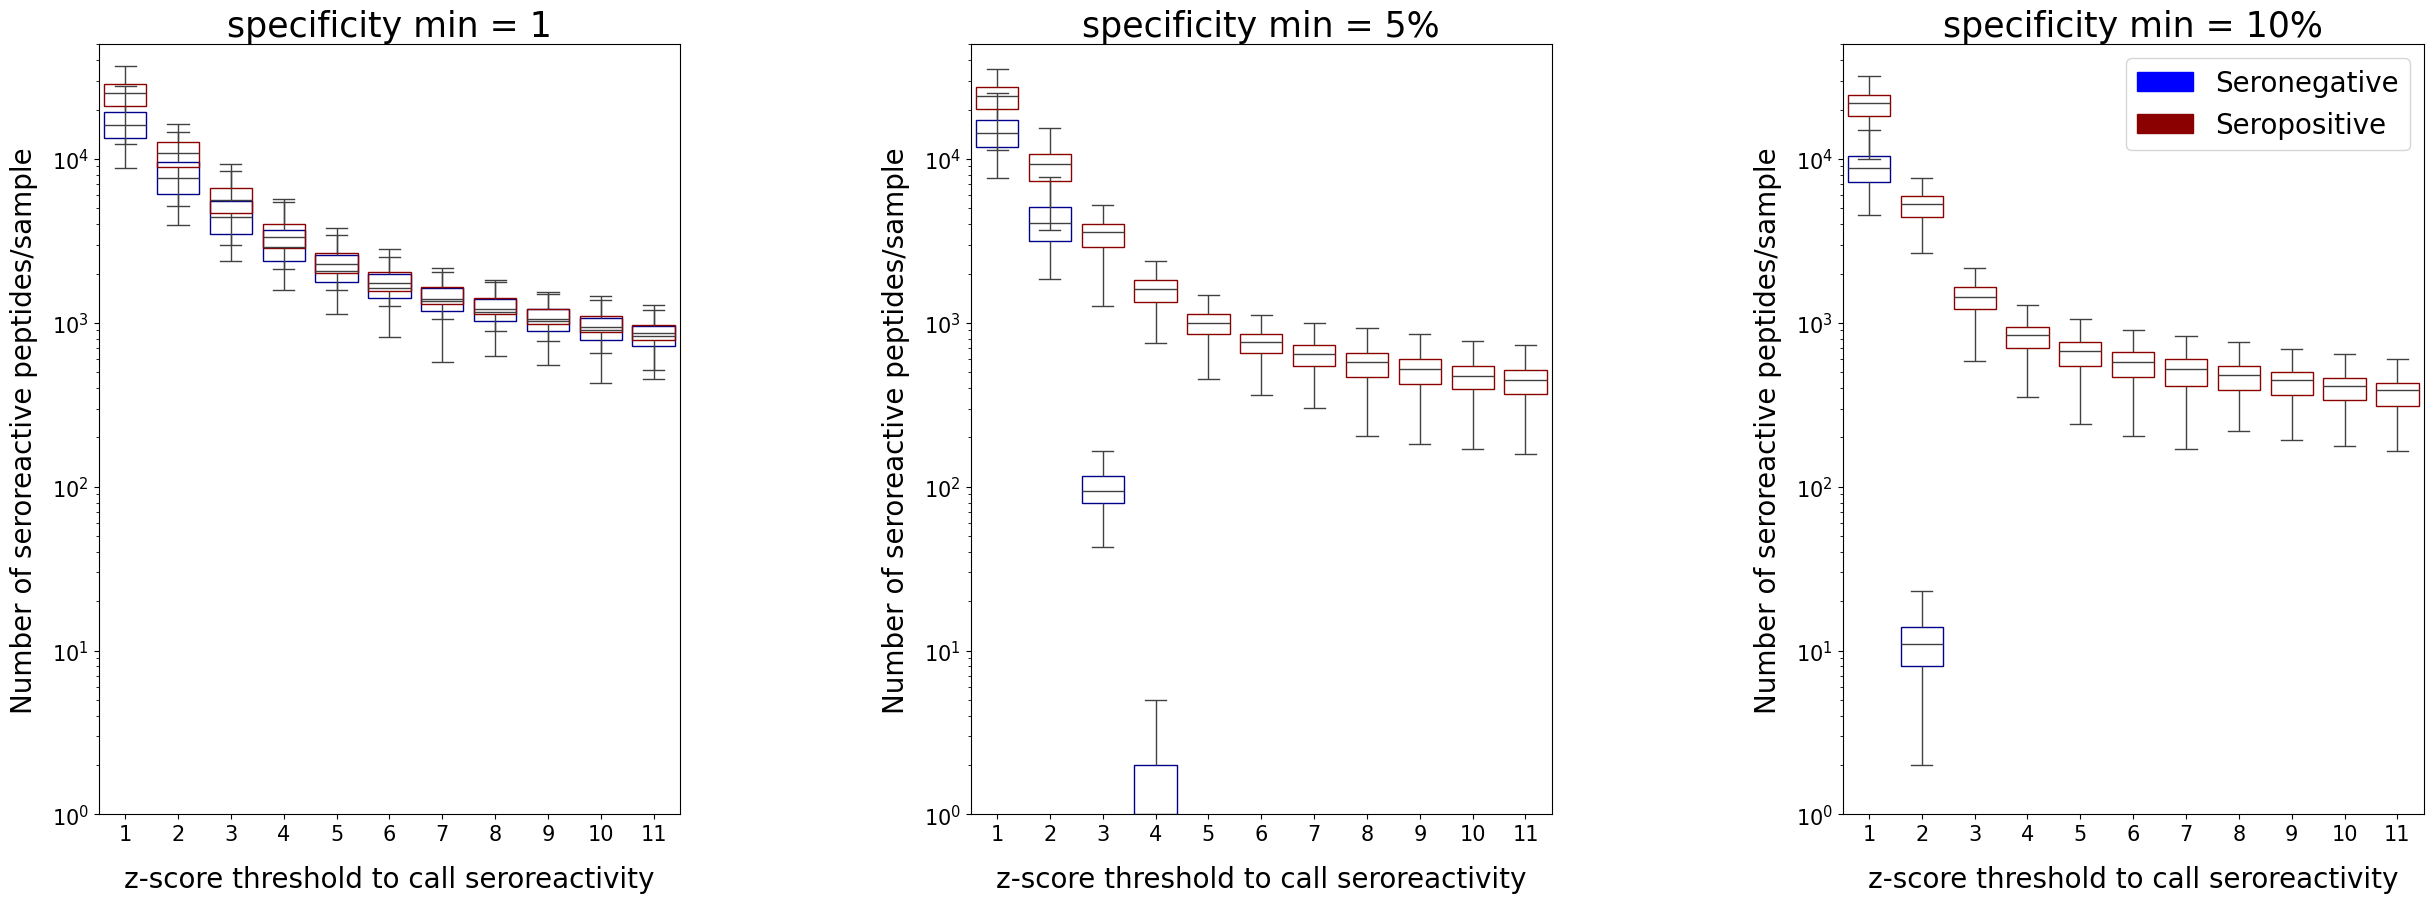

In [39]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(30,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)


sns.boxplot(data = threshold_hit_healthy_cmin1.T,showfliers=False,color = 'darkblue',boxprops=dict(facecolor=(0,0,0,0), edgecolor='darkblue'),ax=ax1)
sns.boxplot(data = threshold_hit_patient_cmin1.T,showfliers=False,color = 'darkred',boxprops=dict(facecolor=(0,0,0,0), edgecolor='darkred'),ax=ax1)
ax1.grid(False)
ax1.set_yscale('log')
ax1.set_ylim(1,50000)
ax1.set_xlabel('z-score threshold to call seroreactivity',size=20,labelpad=15)
ax1.set_ylabel('Number of seroreactive peptides/sample',size=20,labelpad = 10)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax1.set_facecolor('xkcd:white')
ax1.set_title('specificity min = 1',size=25)


sns.boxplot(data = threshold_hit_healthy_cmin5.T,showfliers=False,color = 'darkblue',boxprops=dict(facecolor=(0,0,0,0), edgecolor='darkblue'),ax=ax2)
sns.boxplot(data = threshold_hit_patient_cmin5.T,showfliers=False,color = 'darkred',boxprops=dict(facecolor=(0,0,0,0), edgecolor='darkred'),ax=ax2)
ax2.set_yscale('log')
ax2.set_ylim(1,50000)
ax2.grid(False)
ax2.set_xlabel('z-score threshold to call seroreactivity',size=20,labelpad=15)
ax2.set_ylabel('Number of seroreactive peptides/sample',size=20,labelpad = 10)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax2.set_facecolor('xkcd:white')

ax2.set_title('specificity min = 5%',size=25)


sns.boxplot(data = threshold_hit_healthy_cmin8.T,showfliers=False,color = 'darkblue',boxprops=dict(facecolor=(0,0,0,0), edgecolor='darkblue'),ax=ax3)
sns.boxplot(data = threshold_hit_patient_cmin8.T,showfliers=False,color = 'darkred',boxprops=dict(facecolor=(0,0,0,0), edgecolor='darkred'),ax=ax3)
ax3.set_yscale('log')
ax3.set_ylim(1,50000)
ax3.grid(False)
ax3.set_xlabel('z-score threshold to call seroreactivity',size=20,labelpad=15)
ax3.set_ylabel('Number of seroreactive peptides/sample',size=20,labelpad = 10)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax3.set_facecolor('xkcd:white')
ax3.set_title('specificity min = 10%',size=25)


seroneg_patch = Patch(color='blue', label='Seronegative')
seropos_patch = Patch(color='darkred', label='Seropositive')
plt.legend(handles=[seroneg_patch, seropos_patch], prop={'size': 20})
plt.savefig(fig_dir+'sfig_3b.pdf',dpi=800,bbox_inches='tight')
plt.show()

## ARC

In [40]:
# extract df with pt ids and z-scores
z_score_bd = pd.DataFrame(data=bd.layers['z_score'], columns=bd.var_names, index=bd.obs_names).T
## check that sample names are column names 
z_score_bd.head()

,tclib_A10_S1196_R1_001,tclib_A11_S1197_R1_001,tclib_A12_S1198_R1_001,tclib_A7_S1193_R1_001,tclib_A8_S1194_R1_001,tclib_A9_S1195_R1_001,tclib_B10_S1208_R1_001,tclib_B11_S1209_R1_001,tclib_B12_S1210_R1_001,tclib_B1_S1199_R1_001,...,tclib_H1_S1271_R1_001,tclib_H2_S1272_R1_001,tclib_H3_S1273_R1_001,tclib_H4_S1274_R1_001,tclib_H5_S1275_R1_001,tclib_H6_S1276_R1_001,tclib_H7_S1277_R1_001,tclib_H8_S1278_R1_001,tclib_H9_S1279_R1_001,tclib_library_S1192_R1_001
peptide,,,,,,,,,,,,,,,,,,,,,
XP_802133.1_cystathionine_beta-synthase_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag1,-0.264764,-0.482225,-0.470760,-0.470760,-0.482225,-0.470760,-0.482225,-0.470760,-0.470760,-0.482225,...,-0.470760,-0.470760,-0.470760,-0.470760,-0.470760,-0.470760,-0.470760,-0.470760,-0.482225,0.341480
XP_802133.1_cystathionine_beta-synthase_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag2,0.677770,0.024887,-0.774112,0.519843,-0.139165,-0.774112,-0.299459,-0.609466,-0.613563,0.350317,...,2.281814,-0.774112,-0.774112,0.224582,-0.774112,3.424873,-0.612419,1.246578,-0.463864,0.052798
XP_802134.1_heat_shock_protein_70_(HSP70)_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag1,-0.951792,0.158054,-0.564286,-0.578177,1.753534,1.661998,0.932942,0.379319,-0.951792,-0.598895,...,1.277345,-0.573649,0.789722,0.009416,-0.759145,0.018138,-0.391548,-0.368340,-0.988721,0.664441
XP_802134.1_heat_shock_protein_70_(HSP70)_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag2,-0.350473,2.380463,7.815283,-0.706779,-0.002588,-0.349743,2.912925,-0.706779,2.130039,0.723869,...,1.069429,-0.706779,5.583964,-0.706779,0.030042,1.519042,-0.706779,-0.706779,-0.728087,0.557644
XP_802134.1_heat_shock_protein_70_(HSP70)_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag3,-0.567887,2.610793,-0.708828,-0.245144,0.710892,-0.406141,0.556010,-0.227867,1.341163,0.879839,...,-0.410170,0.091476,-1.042039,0.608866,1.605989,-1.208321,-1.047843,-0.706943,0.725128,0.117424


In [41]:
# extract seronegative samples
seroneg_bd = []

for name in z_score_bd.columns:
    if  name in bd[bd.obs['sero']=='seronegative'].obs.index:
        seroneg_bd.append(name)

# extract seropositive samples
seropos_bd = []

for name in z_score_bd.columns:
    if  name in bd[bd.obs['sero']=='seropositive'].obs.index:
        seropos_bd.append(name)

len(seroneg_bd) # should be 26

26

In [42]:
len(seropos_bd) # should be 64

64

In [43]:
threshold_hit_healthy_cmin1 = pd.DataFrame(columns=(z_score_bd.filter(seroneg_bd)).columns)
threshold_hit_patient_cmin1 = pd.DataFrame(columns=(z_score_bd.filter(seropos_bd)).columns) 

threshold_hit_healthy_cmin5 = pd.DataFrame(columns=(z_score_bd.filter(seroneg_bd)).columns)
threshold_hit_patient_cmin5 = pd.DataFrame(columns=(z_score_bd.filter(seropos_bd)).columns)

threshold_hit_healthy_cmin8 = pd.DataFrame(columns=(z_score_bd.filter(seroneg_bd)).columns)
threshold_hit_patient_cmin8 = pd.DataFrame(columns=(z_score_bd.filter(seropos_bd)).columns)

In [44]:
# i sets a threshold for z-score-based hit calling; temp then re-numbers peptides as 0 or 1 based on whether or not they are hits
for i in range (1,12):
    print (i) 
    temp = z_score_bd
    temp = temp.where(temp>=i, 0, inplace= False) ## those below threshold become zero
    temp.where(temp<i, 1, inplace= True) ## those above threshold become one
   
    temp_healthy = temp.filter(seroneg_bd) ##collect the Healthy samples 
    temp_Patient = temp.filter(seropos_bd)
    
    healthyhitsum = temp_healthy.sum(axis=1, numeric_only = True) ## get the total number of hits for each sample
    patienthitsum = temp_Patient.sum(axis=1, numeric_only = True)
    
    healthyhitperc = temp_healthy.sum(axis=1, numeric_only = True)/len(seroneg_bd) ## get the percent of samples for which that pept is a hit
    patienthitperc = temp_Patient.sum(axis=1, numeric_only = True)/len(seropos_bd)
    
    hit = pd.concat([healthyhitsum,patienthitsum],axis=1)
    hit.columns = ['healthy_R3','patient_R3']

    perc = pd.concat([healthyhitperc,patienthitperc],axis=1)
    perc.columns = ['healthy_R3','patient_R3']

    patient_1 = hit[(hit.patient_R3>0)] # gives all peptides that are a hit for at least one patient
    patient_5 = perc[(perc.patient_R3>=.05)] # gives all peptides that are a hit for at least 5% of patients
    patient_8 = perc[(perc.patient_R3>=.1)] # gives all peptides that are a hit for at least 10% of patients
    
    healthy_1 = hit[(hit.healthy_R3>0)]
    healthy_5 = perc[(perc.healthy_R3>=.05)]
    healthy_8 = perc[(perc.healthy_R3>=.1)]

    final_hit_cmin1_pat = temp_Patient.loc[patient_1.index] # subsets df of hits and sample ids for only those peptides that met above sharing thresholds
    final_hit_cmin5_pat = temp_Patient.loc[patient_5.index]
    final_hit_cmin8_pat = temp_Patient.loc[patient_8.index]
    
    final_hit_cmin1_heal = temp_healthy.loc[healthy_1.index]
    final_hit_cmin5_heal = temp_healthy.loc[healthy_5.index]
    final_hit_cmin8_heal = temp_healthy.loc[healthy_8.index]

   
    hit_sum_cmin1_healthy = final_hit_cmin1_heal.sum(axis=0, numeric_only = True) ##get the total of the remaining rows for each column 
    hit_sum_cmin1_patient = final_hit_cmin1_pat.sum(axis=0, numeric_only = True)

    hit_sum_cmin5_healthy = final_hit_cmin5_heal.sum(axis=0, numeric_only = True)
    hit_sum_cmin5_patient = final_hit_cmin5_pat.sum(axis=0, numeric_only = True)

    hit_sum_cmin8_healthy = final_hit_cmin8_heal.sum(axis=0, numeric_only = True)
    hit_sum_cmin8_patient = final_hit_cmin8_pat.sum(axis=0, numeric_only = True)

    threshold_hit_healthy_cmin1.loc[i] = hit_sum_cmin1_healthy
    threshold_hit_patient_cmin1.loc[i] = hit_sum_cmin1_patient
    
    threshold_hit_healthy_cmin5.loc[i] = hit_sum_cmin5_healthy
    threshold_hit_patient_cmin5.loc[i] = hit_sum_cmin5_patient
    
    threshold_hit_healthy_cmin8.loc[i] = hit_sum_cmin8_healthy
    threshold_hit_patient_cmin8.loc[i] = hit_sum_cmin8_patient

1
2
3
4
5
6
7
8
9
10
11


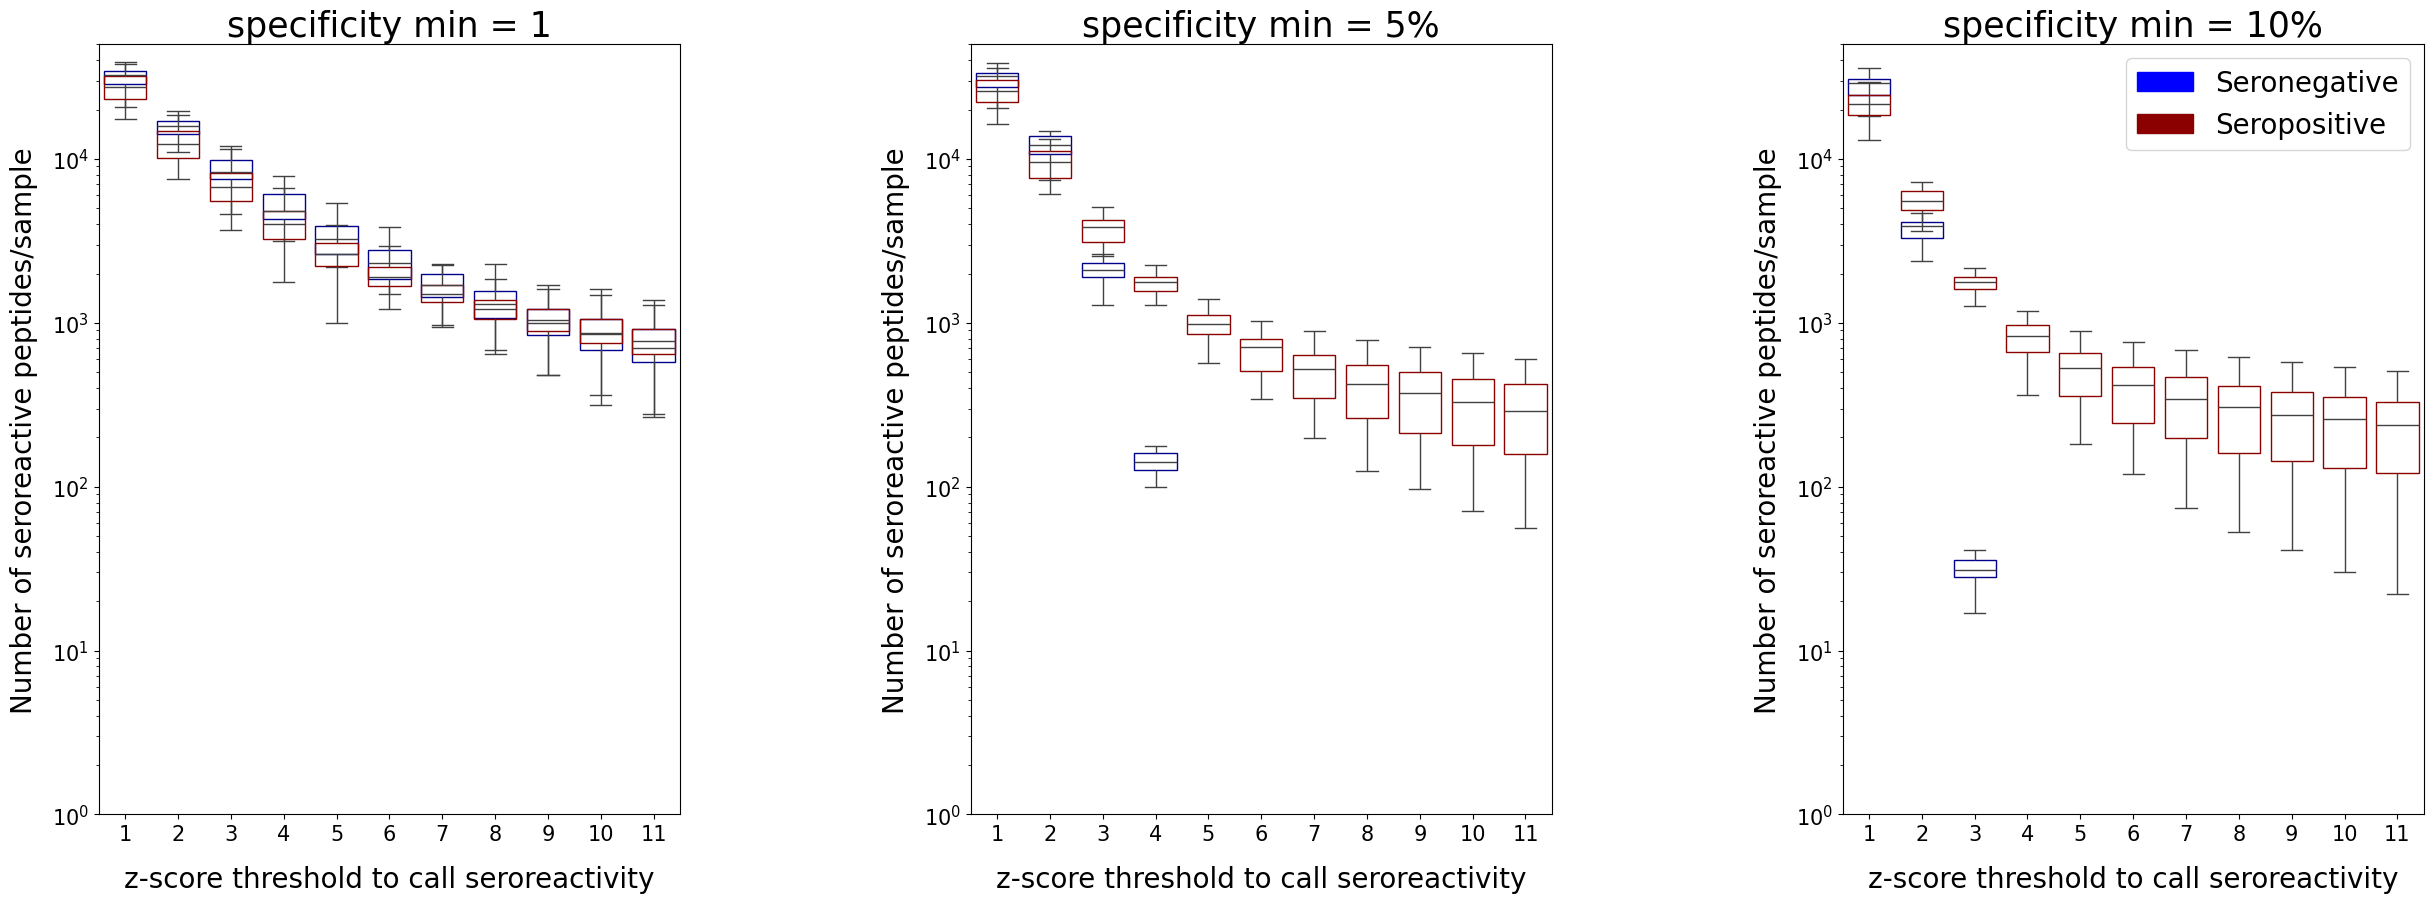

In [45]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(30,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)


sns.boxplot(data = threshold_hit_healthy_cmin1.T,showfliers=False,color = 'darkblue',boxprops=dict(facecolor=(0,0,0,0), edgecolor='darkblue'),ax=ax1)
sns.boxplot(data = threshold_hit_patient_cmin1.T,showfliers=False,color = 'darkred',boxprops=dict(facecolor=(0,0,0,0), edgecolor='darkred'),ax=ax1)
ax1.grid(False)
ax1.set_yscale('log')
ax1.set_ylim(1,50000)
ax1.set_xlabel('z-score threshold to call seroreactivity',size=20,labelpad=15)
ax1.set_ylabel('Number of seroreactive peptides/sample',size=20,labelpad = 10)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax1.set_facecolor('xkcd:white')
ax1.set_title('specificity min = 1',size=25)


sns.boxplot(data = threshold_hit_healthy_cmin5.T,showfliers=False,color = 'darkblue',boxprops=dict(facecolor=(0,0,0,0), edgecolor='darkblue'),ax=ax2)
sns.boxplot(data = threshold_hit_patient_cmin5.T,showfliers=False,color = 'darkred',boxprops=dict(facecolor=(0,0,0,0), edgecolor='darkred'),ax=ax2)
ax2.set_yscale('log')
ax2.set_ylim(1,50000)
ax2.grid(False)
ax2.set_xlabel('z-score threshold to call seroreactivity',size=20,labelpad=15)
ax2.set_ylabel('Number of seroreactive peptides/sample',size=20,labelpad = 10)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax2.set_facecolor('xkcd:white')

ax2.set_title('specificity min = 5%',size=25)


sns.boxplot(data = threshold_hit_healthy_cmin8.T,showfliers=False,color = 'darkblue',boxprops=dict(facecolor=(0,0,0,0), edgecolor='darkblue'),ax=ax3)
sns.boxplot(data = threshold_hit_patient_cmin8.T,showfliers=False,color = 'darkred',boxprops=dict(facecolor=(0,0,0,0), edgecolor='darkred'),ax=ax3)
ax3.set_yscale('log')
ax3.set_ylim(1,50000)
ax3.grid(False)
ax3.set_xlabel('z-score threshold to call seroreactivity',size=20,labelpad=15)
ax3.set_ylabel('Number of seroreactive peptides/sample',size=20,labelpad = 10)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax3.set_facecolor('xkcd:white')
ax3.set_title('specificity min = 10%',size=25)


seroneg_patch = Patch(color='blue', label='Seronegative')
seropos_patch = Patch(color='darkred', label='Seropositive')
plt.legend(handles=[seroneg_patch, seropos_patch], prop={'size': 20})
plt.savefig(fig_dir+'sfig_3a.pdf',dpi=800,bbox_inches='tight')
plt.show()

# Get disease-specific hits

In [46]:
def generate_ds_hits(ad, layer, z_cutoff=5):
    """
    Generates Disease-Specific Hits (ds-hits) at a given cutoff (boolean)
    Ie, given control group, is sample's peptide counts > 3 std. deviations from mean of control group.
    ** Uses leave-one-out z-score **
    
    Parameters
    ----------
    ad: anndata
    layer: str
        layer parameter (ad.layers[`layer_`]) of anndata object with calculated z-scores based on rpk
    z_cutoff: int, default=5
        if z>z_cutoff, then this a DS-hit for the sample 
    
    Returns
    -------
    None 
    
    Notes
    -----
    Saves DS hits under ad.obsm[`DS_z-<z-cutoff>`]
    """
    #take and save SS hits
    ad.obsm['DS_z_{}'.format(z_cutoff)]=pd.DataFrame(data=ad.layers[layer]>z_cutoff,
                                             index=ad.obs.index,
                                             columns=ad.var.index)
    return None

In [47]:
# based on moving threshold analysis (above), z-score >5 looks good for hit calling)
generate_ds_hits(cbm, layer='z_score', z_cutoff=5)
generate_ds_hits(bd, layer='z_score', z_cutoff=5)
cbm

AnnData object with n_obs × n_vars = 230 × 227356
    obs: 'sample_type', 'plate', 'well', 'sample_id', 'rerun', 'group', 'age', 'sex', 'heart_dz', 'sero'
    var: 'refseq_id', 'gene', 'protein', 'seq', 'stage'
    uns: 'control_ids'
    obsm: 'DS_z_5'
    varm: 'X_control'
    layers: 'z_score'

In [48]:
# re-write obsm as array for ease of saving
cbm.obsm['DS_z_5']=np.array(cbm.obsm['DS_z_5'])
bd.obsm['DS_z_5']=np.array(bd.obsm['DS_z_5'])

In [49]:
cbm.write_h5ad(dir+'01_cbm.h5ad')
bd.write_h5ad(dir+'01_bd.h5ad')

# peptide info table - per-peptide hits
This contains information on count and percent of cases and controls with hits for all peptides

In [50]:
def peptide_counts(ad, obsm, obs_name, test, ctrl) -> pd.DataFrame():
    """
     generates peptide table that counts the number of pts with DS hits over z-score threshold in case vs control groups
     
     ad = anndata object name
     obsm = observation matrix name for DS hits (often something like 'DS_z_rpk_#'
     obs_name = obs name that contains disease status
     test = test disease coding (e.g., in an obs for seropositivity, someone seropositive might be "1")
     ctrl = ctrl disease coding (e.g., someone seronegative might be "0")
    
    """
    df = pd.DataFrame(data=None, index=ad.var_names)
    
    test_list = ad[ad.obs[obs_name]==test].obs.index
    ctrl_list = ad[ad.obs[obs_name]==ctrl].obs.index
    
    X_test=ad[test_list,:].obsm[obsm].T
    X_ctrl=ad[ctrl_list,:].obsm[obsm].T
    
    df["no_test"] = np.nansum(X_test,axis=1)
    df["no_ctrl"] = np.nansum(X_ctrl, axis=1)
    
    df["perc_test"] = (df["no_test"]/len(test_list))*100
    df["perc_ctrl"] = (df["no_ctrl"]/len(test_list))*100

    # add gene info
    p2g=pep2gene.gene.to_dict()
    df['gene']=df.index.map(p2g)
    p2g=pep2gene.protein.to_dict()
    df['protein']=df.index.map(p2g)
    p2g=pep2gene.refseq_id.to_dict()
    df['refseq_id']=df.index.map(p2g)
    p2g=pep2gene.seq.to_dict()
    df['seq']=df.index.map(p2g)
    p2g=pep2gene.stage.to_dict()
    df['stage']=df.index.map(p2g)
    
    return df

#usage: peptides = peptide_counts(adata, 'DS_z_5', 'SERO', 1, 2)

In [51]:
cbm_z5 = peptide_counts(cbm, 'DS_z_5', 'sero', 'seropositive', 'seronegative')
cbm_z5.head()

,no_test,no_ctrl,perc_test,perc_ctrl,gene,protein,refseq_id,seq,stage
peptide,,,,,,,,,
XP_802133.1_cystathionine_beta-synthase_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag1,0,1,0.000000,0.877193,Tc00.1047053447925.10,"Cystathionine beta-synthase, putative",XP_802133.1,NGCFHLLPFLFTLLLLLFVFPIGGEDVQIMAQNPSAVNNKKEVPDRR,NaN
XP_802133.1_cystathionine_beta-synthase_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag2,0,1,0.000000,0.877193,Tc00.1047053447925.10,"Cystathionine beta-synthase, putative",XP_802133.1,GEDVQIMAQNPSAVNNKKEVPDRRTCILDTVLDAIGSTHCIRLNHVP,NaN
XP_802134.1_heat_shock_protein_70_(HSP70)_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag1,4,2,3.508772,1.754386,Tc00.1047053418069.10,"Heat shock protein 70 (HSP70), putative",XP_802134.1,VAFTETERLIGDGAKNQLPQNPHNTIYAIKRLIGRKYSDATVQTDKK,NaN
XP_802134.1_heat_shock_protein_70_(HSP70)_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag2,2,1,1.754386,0.877193,Tc00.1047053418069.10,"Heat shock protein 70 (HSP70), putative",XP_802134.1,IKRLIGRKYSDATVQTDKKLLSYEVVADKDGKPKVQVEVGGKKKQFT,NaN
XP_802134.1_heat_shock_protein_70_(HSP70)_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag3,0,1,0.000000,0.877193,Tc00.1047053418069.10,"Heat shock protein 70 (HSP70), putative",XP_802134.1,KDGKPKVQVEVGGKKKQFTPEEVSAMVLQKMKEIAETYLGEKVKNAV,NaN


In [52]:
bd_z5 = peptide_counts(bd, 'DS_z_5', 'sero', 'seropositive', 'seronegative')
bd_z5.head()

,no_test,no_ctrl,perc_test,perc_ctrl,gene,protein,refseq_id,seq,stage
peptide,,,,,,,,,
XP_802133.1_cystathionine_beta-synthase_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag1,0,1,0.0000,1.5625,Tc00.1047053447925.10,"Cystathionine beta-synthase, putative",XP_802133.1,NGCFHLLPFLFTLLLLLFVFPIGGEDVQIMAQNPSAVNNKKEVPDRR,NaN
XP_802133.1_cystathionine_beta-synthase_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag2,0,0,0.0000,0.0000,Tc00.1047053447925.10,"Cystathionine beta-synthase, putative",XP_802133.1,GEDVQIMAQNPSAVNNKKEVPDRRTCILDTVLDAIGSTHCIRLNHVP,NaN
XP_802134.1_heat_shock_protein_70_(HSP70)_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag1,2,0,3.1250,0.0000,Tc00.1047053418069.10,"Heat shock protein 70 (HSP70), putative",XP_802134.1,VAFTETERLIGDGAKNQLPQNPHNTIYAIKRLIGRKYSDATVQTDKK,NaN
XP_802134.1_heat_shock_protein_70_(HSP70)_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag2,7,0,10.9375,0.0000,Tc00.1047053418069.10,"Heat shock protein 70 (HSP70), putative",XP_802134.1,IKRLIGRKYSDATVQTDKKLLSYEVVADKDGKPKVQVEVGGKKKQFT,NaN
XP_802134.1_heat_shock_protein_70_(HSP70)_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag3,2,0,3.1250,0.0000,Tc00.1047053418069.10,"Heat shock protein 70 (HSP70), putative",XP_802134.1,KDGKPKVQVEVGGKKKQFTPEEVSAMVLQKMKEIAETYLGEKVKNAV,NaN


# Chagas-specific per-peptide hits
This filters peptides to only those enriched in seropositive patients at a given sharing threshold

In [53]:
def filtered_hits_cases(counts, perc_test, no_ctrl) -> pd.DataFrame():
    """
     generates filtered peptide table that includes only peptides that are shared by cases and not by controls
     
     counts = peptide count table generated by peptide_counts_hk function
     perc_test = minimum percent of case patients who must share a given peptide to consider it enriched in cases
     no_ctrl = maximum number of control patients who can share a given peptide to consider it enriched in cases only
    
    """
    df = counts.loc[(counts["perc_test"]>=perc_test)
    & (counts["no_ctrl"]<=no_ctrl)
    ,: ]
    
    return df

#usage: case_pept = filtered_hits_cases(peptides, 5, 1)

In [54]:
chagas_pept_cbm = filtered_hits_cases(cbm_z5, 5, 1)
chagas_pept_cbm.shape

(5640, 9)

In [55]:
# filter for only T. cruzi peptides
filtered_peptides = pep2gene[pep2gene['organism'] == 'Trypanosoma cruzi (strain CL Brener)'].index
len(filtered_peptides)

228127

In [56]:
chagas_pept_cbm = chagas_pept_cbm[chagas_pept_cbm.index.isin(filtered_peptides)]
chagas_pept_cbm.shape

(5638, 9)

In [57]:
chagas_pept_bd = filtered_hits_cases(bd_z5, 5, 1)
chagas_pept_bd.shape

(8711, 9)

In [58]:
chagas_pept_bd = chagas_pept_bd[chagas_pept_bd.index.isin(filtered_peptides)]
chagas_pept_bd.shape

(8710, 9)

In [59]:
# sort by seroprevalence
chagas_pept_bd = chagas_pept_bd.sort_values(by='perc_test',ascending=False)
chagas_pept_cbm = chagas_pept_cbm.sort_values(by='perc_test',ascending=False)

In [60]:
chagas_pept_cbm.to_csv(dir+'01_cbm_pept.csv')
chagas_pept_bd.to_csv(dir+'01_bd_pept.csv')